In [18]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import optim

In [19]:
#Setup and train a simple neural network
def build_NN(dropout_p):
    NN = torch.nn.Sequential(
        torch.nn.Linear(1, 20),
        torch.nn.SELU(),
        torch.nn.AlphaDropout(p=dropout_p),
        torch.nn.Linear(20, 20),
        torch.nn.SELU(),
        torch.nn.AlphaDropout(p=dropout_p),
        torch.nn.Linear(20, 20),
        torch.nn.SELU(),
        torch.nn.AlphaDropout(p=dropout_p),
        torch.nn.Linear(20, 1),
    )    
    return NN

In [20]:
#Setup a generic training function
def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    return output.item()

In [22]:
def gen_train_data(N=100):
    mu, sigma = 0, 0.05
    w = np.random.normal(mu, sigma, N)
    x = np.concatenate((np.random.uniform(0,0.6,int(N/2)), np.random.uniform(0.8,1,int(N/2))))
    alpha = 4
    beta = 13
    y = x + np.sin(alpha*(x+w)) + np.sin(beta*(x+w)) + w
    #y = x**3 + w
    
    return (torch.from_numpy(x).float().view(-1, 1), 
            torch.from_numpy(y).float().view(-1, 1)) #Ensure that the variables are Nx1

#Collect training data
N = 100
(x_train, y_train) = gen_train_data(N)

In [23]:
def true_function(x):
    alpha = 4
    beta = 13
    y = x + np.sin(alpha*x) + np.sin(beta*x)
    return y

In [42]:
def plot_training_data(fig, ax, x_train, y_train, x_test, y_test, title):
    ax.clear()
    ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_xlim(-1,2)
    #ax.set_ylim(-8,8)
    ax.set_title(title)
    x_true = np.arange(-2,2, 0.05)
    y_true = true_function(x_true)
    
    ax.plot(x_test, y_test, c='grey')
    ax.scatter(x_train, y_train, c='g', alpha=0.5)
    ax.scatter(x_true, y_true, c='c', alpha=0.5)

    return x_true    

In [46]:
def plot_predictions(fig, ax, model, stoch_passes,  x_train, y_train, title):
    #Plot initial training data
    ax.clear()

    (x_t_plt) = plot_training_data(fig, ax, x_train, y_train, [],[],title)

    #Test samples
    num_test_samples = x_t_plt.shape[0]
    
    #Copies each element in x_t M times
    M = stoch_passes
    x_t = np.broadcast_to(x_t_plt, (M, num_test_samples)).T.flatten() 
    x_t = Variable(torch.from_numpy(x_t).float().view(-1,1), requires_grad=False)
    
    #Evaluate the model
    y_t = model.forward(x_t).data.view(-1).numpy()
    
    #Compute empirical means for each x_t pass
    y_t = y_t.reshape((num_test_samples, M))
    
    
    y_t_mean = np.mean(y_t, axis=1)
    y_t_sigma = np.sqrt(np.var(y_t, axis=1))
    
    #
    n_ll = compute_nll(y_t_mean, true_function(x_t_plt), y_t_sigma**2)
    ax.text(0, 0, 'NLL = {:.2f}'.format(n_ll), bbox=dict(facecolor='white'))

    ax.plot(x_t_plt, y_t_mean, c='k')
    ax.fill_between(x_t_plt, y_t_mean - y_t_sigma, y_t_mean + y_t_sigma, facecolor='blue', alpha=0.7)
    ax.fill_between(x_t_plt, y_t_mean - 2*y_t_sigma, y_t_mean + 2*y_t_sigma, facecolor='blue', alpha=0.5)
    ax.fill_between(x_t_plt, y_t_mean - 3*y_t_sigma, y_t_mean + 3*y_t_sigma, facecolor='blue', alpha=0.2)


    fig.canvas.draw()
    fig.show()


In [47]:
def compute_nll(y_pred, y_true, sigma2_pred):
    losses = (0.5/(sigma2_pred))*(y_pred - y_true)**2 + 0.5*np.log(sigma2_pred) + 0.5*np.log(2*np.pi)
    return np.mean(losses)

Epoch 1, cost = 0.885779
Epoch 51, cost = 0.389051
Epoch 101, cost = 0.356444
Epoch 151, cost = 0.317581
Epoch 201, cost = 0.321488
Epoch 251, cost = 0.306076
Epoch 301, cost = 0.305603
Epoch 351, cost = 0.342313
Epoch 401, cost = 0.311276
Epoch 451, cost = 0.300455
Epoch 501, cost = 0.296729
Epoch 551, cost = 0.310847
Epoch 601, cost = 0.297635
Epoch 651, cost = 0.307277
Epoch 701, cost = 0.313633
Epoch 751, cost = 0.302501
Epoch 801, cost = 0.309736
Epoch 851, cost = 0.309329
Epoch 901, cost = 0.291663
Epoch 951, cost = 0.330949


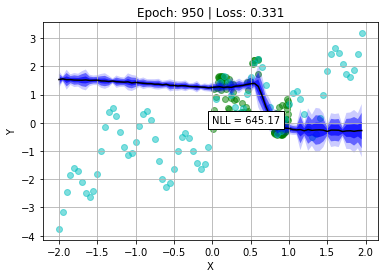

In [51]:
#Train!
dropout_p = 0.01
batch_size = 10
l2 = 5e-7
tau_inv = 0.01
l2_decay = l2 * (1 - dropout_p)* tau_inv / (2 * N)
stoch_passes = 50

model = build_NN(dropout_p)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=l2_decay)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for e in range(1000):
    num_batches = N // batch_size
    cost = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost += train(model, loss, optimizer, x_train[start:end], y_train[start:end])
        
    if (e)%50 == 0:
        print("Epoch %d, cost = %f" % (e + 1, cost / num_batches))
        plot_predictions(fig, ax, model, stoch_passes, x_train.numpy(), y_train.numpy(), "Epoch: {} | Loss: {:.3f}".format(e, cost/num_batches))

In [ ]:
#Now use bootstrapping!
#Let's do a naive bootstrap - train the model ten times on different subsets of the data
#Don't use dropout
dropout_p = 0
num_models = 10
model_list = []
for m_i in range(num_models):
    
    #Sample with replacement
    indices = torch.from_numpy(np.random.choice(N, N, replace=True))
    x_train_i = x_train[indices]
    y_train_i = y_train[indices]
    
    model = build_NN(dropout_p)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for e in range(2000):
        num_batches = N // batch_size
        cost = 0.
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += train(model, loss, optimizer, x_train_i[start:end], y_train_i[start:end])
        if (e)%1000 == 0:
            print("Model %d, epoch %d, cost = %f" % (m_i, e + 1, cost / num_batches))
    
    model_list.append(model)


In [ ]:
#Now using our models, lets compute mean and std
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
ax.clear()
title = 'Bootstrap'
x_t_plt = plot_training_data(fig, ax, x_train.numpy(), y_train.numpy(), title)
x_t = Variable(torch.from_numpy(x_t_plt).float().view(-1,1), requires_grad=False)
y_t = np.zeros((num_models, x_t_plt.shape[0]))

for m_i in range(num_models):
    #Evaluate the model
    y_t[m_i] = model_list[m_i].forward(x_t).data.view(-1).numpy()


y_t_mean = np.mean(y_t, axis=0)
y_t_sigma = np.sqrt(np.var(y_t, axis=0))
n_ll = compute_nll(y_t_mean, true_function(x_t_plt), y_t_sigma**2)
ax.text(-2, 7, 'NLL = {:.2f}'.format(n_ll), bbox=dict(facecolor='white'))

ax.plot(x_t_plt, y_t_mean, c='k')
ax.fill_between(x_t_plt, y_t_mean - y_t_sigma, y_t_mean + y_t_sigma, facecolor='blue', alpha=0.7)
ax.fill_between(x_t_plt, y_t_mean - 2*y_t_sigma, y_t_mean + 2*y_t_sigma, facecolor='blue', alpha=0.5)
ax.fill_between(x_t_plt, y_t_mean - 3*y_t_sigma, y_t_mean + 3*y_t_sigma, facecolor='blue', alpha=0.2)
fig.canvas.draw()

In [ ]:
#Now construct a new bootstrap-esque hydra, without subsampling
def build_hydra(num_heads, num_outputs=1):
    class HydraHead(torch.nn.Module):
        def __init__(self, n_o):
            super(HydraHead, self).__init__()

            self.head_net = torch.nn.Sequential(
                     torch.nn.Linear(20, 20),
                     torch.nn.SELU(),
                     torch.nn.Linear(20, n_o))
            
        def forward(self, x):
            return self.head_net(x)
            
    class HydraNet(torch.nn.Module):
        def __init__(self, num_heads, num_outputs):
            super(HydraNet, self).__init__()
            self.shared_net = torch.nn.Sequential(
                torch.nn.Linear(1, 20),
                torch.nn.SELU(),
                torch.nn.Linear(20, 20),
                torch.nn.SELU()
            )
            #Initialize the heads
            self.num_heads = num_heads
            self.num_outputs = num_outputs
            self.heads = [HydraHead(n_o=num_outputs) for h in range(num_heads)]
            
        def forward(self, x):
            y = self.shared_net(x)
            y_out = [head_net(y) for head_net in self.heads]
            
            if self.num_outputs > 1:
                #Return [N_batch, Heads, N_outputs] arrary
                return torch.cat(y_out, 1).view(-1, self.num_heads, self.num_outputs)
            else:
                return torch.cat(y_out, 1)
            
    net = HydraNet(num_heads, num_outputs)
    return net

In [ ]:
def plot_predictions_hydra(fig, ax, model,  x_train, y_train, title):
    ax.clear()
    x_t_plt = plot_training_data(fig, ax, x_train, y_train, title)
    
    x_t_plt = np.arange(-2,2,0.01)
    num_test_samples = x_t_plt.shape[0]
    x_t = Variable(torch.from_numpy(x_t_plt).float().view(-1,1), requires_grad=False)
    
    #Evaluate the model
    y_t = model.forward(x_t).data.view(-1).numpy()
    
    #Compute empirical means for each head
    y_t = y_t.reshape((num_test_samples, model.num_heads))
    
    y_t_mean = np.mean(y_t, axis=1)
    y_t_sigma = np.sqrt(np.var(y_t, axis=1))
    
    n_ll = compute_nll(y_t_mean, true_function(x_t_plt), y_t_sigma**2)
    ax.text(-2, 7, 'NLL = {:.2f}'.format(n_ll), bbox=dict(facecolor='white'))


    
    ax.plot(x_t_plt, y_t_mean, c='k')
    ax.fill_between(x_t_plt, y_t_mean - y_t_sigma, y_t_mean + y_t_sigma, facecolor='blue', alpha=0.7)
    ax.fill_between(x_t_plt, y_t_mean - 2*y_t_sigma, y_t_mean + 2*y_t_sigma, facecolor='blue', alpha=0.5)
    ax.fill_between(x_t_plt, y_t_mean - 3*y_t_sigma, y_t_mean + 3*y_t_sigma, facecolor='blue', alpha=0.2)
    
    fig.canvas.draw()

In [ ]:
num_heads = 10
batch_size = 10
model = build_hydra(num_heads)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

#Duplicate the targets for each of the 'heads'
y_train_hydra =  y_train.squeeze(1).repeat(num_heads,1).t()

#Set up our monitoring plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for e in range(5000):
    num_batches = N // batch_size
    cost = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost += train(model, loss, optimizer, x_train[start:end], y_train_hydra[start:end])
        
    if (e)%50 == 0:
        #print("Epoch %d, cost = %f" % (e + 1, cost / num_batches))
        plot_predictions_hydra(fig, ax, model, x_train.numpy(), y_train.numpy(), "Epoch: {} | Cost: {:.3f}".format(e, cost/num_batches))

# Method IV: Learn Sigma Directly

In [ ]:
#Third method -> Learn sigma directly
def build_NN_sigma():
    NN = torch.nn.Sequential(
        torch.nn.Linear(1, 20),
        torch.nn.SELU(),
        torch.nn.Linear(20, 20),
        torch.nn.SELU(),
        torch.nn.Linear(20, 20),
        torch.nn.SELU(),
        torch.nn.Linear(20, 2)
    )    
    return NN

#Create a new loss with a sigma-squared term
class GaussianLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianLoss, self).__init__()
    
    #Based on negative log of normal distribution
    def forward(self, input, target):
        mean = input[:, 0]
        sigma2 = torch.log(1 + torch.exp(input[:, 1])) + 1e-6
        loss = torch.mean(0.5*(mean - target.squeeze())*((mean - target.squeeze())/sigma2) + 0.5*torch.log(sigma2))
        return loss

In [ ]:
def plot_predictions_sigma(fig, ax, model, x_train, y_train, title):
    ax.clear()
    x_t_plt = plot_training_data(fig, ax, x_train, y_train, title)


    num_test_samples = x_t_plt.shape[0]
    x_t = Variable(torch.from_numpy(x_t_plt).float().view(-1,1), requires_grad=False)
    
    #Evaluate the model
    model.eval()
    y_t = model.forward(x_t).data.numpy()
    
    #Compute empirical means for each x_t pass
    y_t_mean = y_t[:, 0]
    y_t_sigma = np.sqrt(np.log(1 + np.exp(y_t[:, 1])) + 1e-6)
    
    n_ll = compute_nll(y_t_mean, true_function(x_t_plt), y_t_sigma**2)
    ax.text(-2, 7, 'NLL = {:.2f}'.format(n_ll), bbox=dict(facecolor='white'))

    ax.plot(x_t_plt, y_t_mean, c='k')
    ax.fill_between(x_t_plt, y_t_mean - y_t_sigma, y_t_mean + y_t_sigma, facecolor='blue', alpha=0.7)
    ax.fill_between(x_t_plt, y_t_mean - 2*y_t_sigma, y_t_mean + 2*y_t_sigma, facecolor='blue', alpha=0.5)
    ax.fill_between(x_t_plt, y_t_mean - 3*y_t_sigma, y_t_mean + 3*y_t_sigma, facecolor='blue', alpha=0.2)
    
    fig.canvas.draw()

In [ ]:
model = build_NN_sigma()
loss = GaussianLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
batch_size = 10

#Set up our monitoring plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for e in range(5000):
    num_batches = N // batch_size
    cost = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost += train(model, loss, optimizer, x_train[start:end], y_train[start:end])
        
    if (e)%50 == 0:
        #print("Epoch %d, cost = %f" % (e + 1, cost / num_batches))
        plot_predictions_sigma(fig, ax, model, x_train.numpy(), y_train.numpy(), "Epoch: {} | Cost: {:.3f}".format(e, cost/num_batches))

# Hydra + Bayesian Conjugate Priors
Assuming Gaussian likelihood, we can set a normal-inverse gamma prior on the mean and variance $$\mu, \sigma^2$$ parametrized by $$\mu_0, \nu, \alpha, \beta$$.

Then compute,
$$\beta' = \beta +{\tfrac {1}{2}}\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}+{\frac {n\nu }{\nu +n}}{\frac {({\bar {x}}-\mu _{0})^{2}}{2}}
\mu' = {\frac {\nu \mu _{0}+n{\bar {x}}}{\nu +n}}, \nu' = \nu +n,\,\alpha' = \alpha +{\frac {n}{2}}
$$
Our posterior predictive distribution mean and variances are given by
$$
\mu', \frac {\beta '(\nu '+1)}{\nu '\alpha '}
$$
See:
https://en.wikipedia.org/wiki/Conjugate_prior

In [ ]:
# def plot_predictions_hydra_bayesian(fig, ax, model,  x_train, y_train, title):
#     ax.clear()
#     plot_training_data(fig, ax, x_train, y_train, title)

#     #model.eval()
#     x_t_plt = np.arange(-5,5,0.01)
    
#     num_test_samples = x_t_plt.shape[0]
#     x_t = Variable(torch.from_numpy(x_t_plt).float().view(-1,1), requires_grad=False)
    
#     #Evaluate the model
#     y_t = model.forward(x_t).data.view(-1).numpy()
    
#     #Compute empirical means for each x_t pass
#     y_t = y_t.reshape((num_test_samples, model.num_heads))
    
#     #Set up conjugate gradients
#     alpha = 3
#     beta = 0.5
#     nu = 5
#     mu_0 = 0
#     n = model.num_heads
        
#     beta_prime = beta + 0.5*np.sum((y_t - y_t.mean(axis=1, keepdims=True))**2, axis=1)
#     beta_prime = beta_prime + (n*nu/(nu+n))*0.5*(y_t.mean(axis=1) - mu_0)**2
    
#     mu_prime =  (1/(nu+n))*(nu*mu_0 + n*y_t.mean(axis=1))
#     nu_prime = nu + n
#     alpha_prime = alpha + n/2.0
    
    
#     y_t_mean =  mu_prime
#     y_t_sigma2 = beta_prime*(nu_prime + 1)/(nu_prime*alpha_prime)
#     y_t_sigma = np.sqrt(y_t_sigma2)

#     ax.plot(x_t_plt, y_t_mean, c='k')
#     ax.fill_between(x_t_plt, y_t_mean - y_t_sigma, y_t_mean + y_t_sigma, facecolor='blue', alpha=0.7)
#     ax.fill_between(x_t_plt, y_t_mean - 2*y_t_sigma, y_t_mean + 2*y_t_sigma, facecolor='blue', alpha=0.5)
#     ax.fill_between(x_t_plt, y_t_mean - 3*y_t_sigma, y_t_mean + 3*y_t_sigma, facecolor='blue', alpha=0.2)
    
#     fig.canvas.draw()

In [ ]:
# num_heads = 10
# model = build_hydra(num_heads)
# loss = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# #Duplicate the targets for each of the 'heads'
# y_train_hydra =  y_train.squeeze(1).repeat(num_heads,1).t()

# #Set up our monitoring plot
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.show()
# fig.canvas.draw()

# for e in range(5000):
#     num_batches = N // batch_size
#     cost = 0.
#     for k in range(num_batches):
#         start, end = k * batch_size, (k + 1) * batch_size
#         cost += train(model, loss, optimizer, x_train[start:end], y_train_hydra[start:end])
        
#     if (e)%10 == 0:
#         #print("Epoch %d, cost = %f" % (e + 1, cost / num_batches))
#         plot_predictions_hydra_bayesian(fig, ax, model, x_train.numpy(), y_train.numpy(), "Epoch: {} | Cost: {:.3f}".format(e, cost/num_batches))

# Mixture of Gaussians (with Hydra and dual learning)

In [ ]:
#Create a new loss with a sigma-squared term
class GaussianHydraLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianHydraLoss, self).__init__()
    
    #Based on negative log of normal distribution
    def forward(self, input, target):
        mean = input[:, :, 0]
        sigma2 = torch.log(1 + torch.exp(input[:, :, 1])) + 1e-6
        loss = torch.mean(0.5*(mean - target)*((mean - target)/sigma2) + 0.5*torch.log(sigma2))
        return loss

In [ ]:
def plot_predictions_hydra_sigma(fig, ax, model, x_train, y_train, title):
    ax.clear()
    x_t_plt = plot_training_data(fig, ax, x_train, y_train, title)

    num_test_samples = x_t_plt.shape[0]
    x_t = Variable(torch.from_numpy(x_t_plt).float().view(-1,1), requires_grad=False)
    
    #Evaluate the model
    model.eval()
    y_t = model.forward(x_t).data.numpy()
    n = model.num_heads
    
    
    mu_i = y_t[:,:,0]
    mu_star = np.mean(mu_i, axis=1) #The means of the predictions
    sigma2_i = np.log(1 + np.exp(y_t[:, :, 1])) + 1e-6
    sigma_star = np.sqrt(np.mean(sigma2_i + mu_i**2, axis=1) - mu_star**2)
    
    n_ll = compute_nll(mu_star, true_function(x_t_plt), sigma_star**2)
    ax.text(-2, 7, 'NLL = {:.2f}'.format(n_ll), bbox=dict(facecolor='white'))
    
    ax.plot(x_t_plt, mu_star, c='k')
    ax.fill_between(x_t_plt, mu_star - sigma_star, mu_star + sigma_star, facecolor='blue', alpha=0.7)
    ax.fill_between(x_t_plt, mu_star - 2*sigma_star, mu_star + 2*sigma_star, facecolor='blue', alpha=0.5)
    ax.fill_between(x_t_plt, mu_star - 3*sigma_star, mu_star + 3*sigma_star, facecolor='blue', alpha=0.2)
    
    fig.canvas.draw()

In [ ]:
num_heads = 10
model = build_hydra(num_heads, num_outputs=2)
loss = GaussianHydraLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.5)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 10
#Set up our monitoring plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
#Duplicate the targets for each of the 'heads'
y_train_hydra =  y_train.squeeze(1).repeat(num_heads,1).t()

for e in range(5000):
    num_batches = N // batch_size
    cost = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost += train(model, loss, optimizer, x_train[start:end], y_train_hydra[start:end])
        
    if (e)%50 == 0:
        #print("Epoch %d, cost = %f" % (e + 1, cost / num_batches))
        plot_predictions_hydra_sigma(fig, ax, model, x_train.numpy(), y_train.numpy(), "Epoch: {} | Cost: {:.3f}".format(e, cost/num_batches))